In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
from scipy import integrate

In [2]:
from scipy.signal import find_peaks

In [78]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['savefig.facecolor'] = 'w'
plt.rcParams['grid.color'] = '#C0C0C0'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16
lw = 2

In [5]:
folder = "./batch3"

In [6]:
imufile = folder + "/gyro_accel.csv"
viconfile = folder + "/vicon_capture_quaternion.csv"
# viconfile = folder + "/vicon_capture_helical.csv"

In [7]:
imu_data = pd.read_csv(imufile)

In [8]:
vicon_data = pd.read_csv(viconfile)

## IMU data description
- Timestamp  nanosec
- gx/gy/gz   rad/s
- ax/ay/az   m/s^2

In [9]:
imu_data.head()

,Timestamp,gx,gy,gz,ax,ay,az
0,2501493224909709,0.161879,-0.091019,0.056200,0.746991,1.927332,9.931149
1,2501493229914632,0.188146,-0.051924,0.076969,0.660800,1.924938,9.921572
2,2501493235581094,0.209527,-0.014050,0.097738,0.632069,1.889025,9.919178
3,2501493239924171,0.224798,0.026878,0.119119,0.543484,1.836353,9.866506
4,2501493244929171,0.237627,0.058032,0.141721,0.442927,1.838747,9.821015


In [10]:
imu_data.describe()

,Timestamp,gx,gy,gz,ax,ay,az
count,9.196170e+05,919617.000000,919617.000000,919617.000000,919617.000000,919617.000000,919617.000000
mean,2.503792e+15,0.008027,0.001625,0.002030,-0.032782,0.446559,8.007794
std,1.327354e+12,0.133171,0.468709,0.095684,5.363180,0.527052,1.796492
min,2.501493e+15,-9.305310,-3.631594,-1.528996,-36.806065,-27.559656,-28.646624
25%,2.502643e+15,-0.043982,-0.400728,-0.040928,-4.740520,0.088585,6.605602
50%,2.503792e+15,0.000611,0.000000,0.000611,-0.122104,0.418985,8.362946
75%,2.504942e+15,0.061087,0.414167,0.043982,4.920084,0.775721,9.588778
max,2.506091e+15,3.105028,5.660888,1.742188,16.302120,6.030994,78.443630


## Vicon data description

- RX/RY/RZ/RW  quaternion
- TX/TY/TZ     mm

In [11]:
vicon_data.head()

,Frame,Sub Frame,RX,RY,RZ,RW,TX,TY,TZ
0,1,0.0,-0.005036,-0.005135,0.147435,0.989046,-119.557,37.3470,13.5286
1,2,0.0,-0.005784,-0.005795,0.147644,0.989007,-119.588,37.4649,13.6240
2,3,0.0,-0.005963,-0.005937,0.147684,0.988999,-119.577,37.4501,13.6382
3,4,0.0,-0.005186,-0.005159,0.147369,0.989055,-119.548,37.3299,13.5118
4,5,0.0,-0.004757,-0.004834,0.147335,0.989063,-119.534,37.3583,13.5092


In [12]:
vicon_data.describe()

,Frame,Sub Frame,RX,RY,RZ,RW,TX,TY,TZ
count,443161.00000,443007.0,443007.000000,443007.000000,443007.000000,443007.000000,443007.000000,443007.000000,443007.000000
mean,221581.00000,0.0,0.016910,-0.009264,0.021997,0.951699,-5.704886,-27.062110,156.749626
std,127929.70566,0.0,0.025326,0.293622,0.059670,0.054750,243.581595,120.211399,96.839358
min,1.00000,0.0,-0.277832,-0.582355,-0.282980,-0.175890,-3237.270000,-2392.300000,12.549900
25%,110791.00000,0.0,-0.004715,-0.275795,-0.003824,0.916929,-136.290000,-32.044950,117.575000
50%,221581.00000,0.0,0.016316,-0.004136,0.015563,0.963801,-41.259300,-19.532600,160.542000
75%,332371.00000,0.0,0.033937,0.244229,0.032753,0.990971,175.000000,-6.191615,201.171000
max,443161.00000,0.0,0.198903,0.558865,0.999639,0.999998,365.803000,222.149000,1341.990000


## Timestamp alignment

### IMU Start

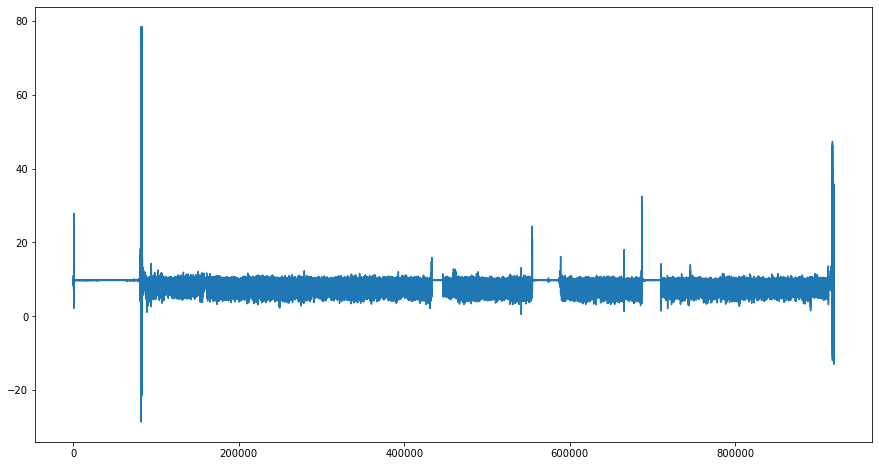

In [102]:
plt.plot(imu_data['az'])

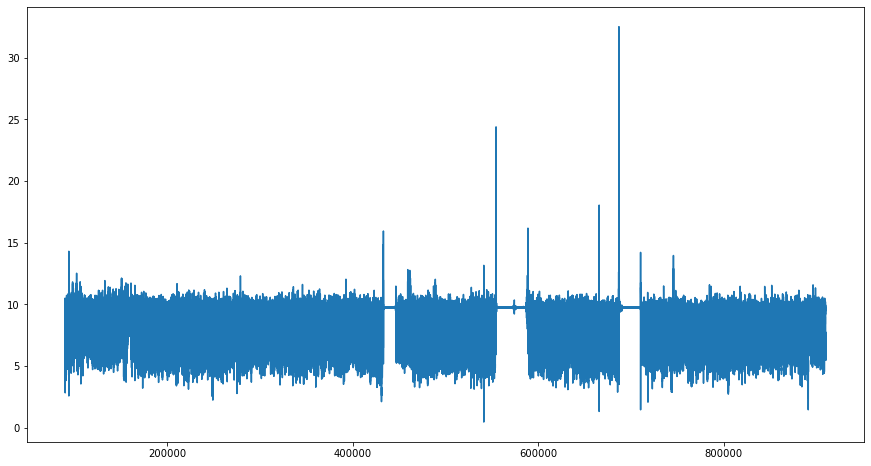

In [103]:
plt.plot(imu_data['az'][90000:910000])

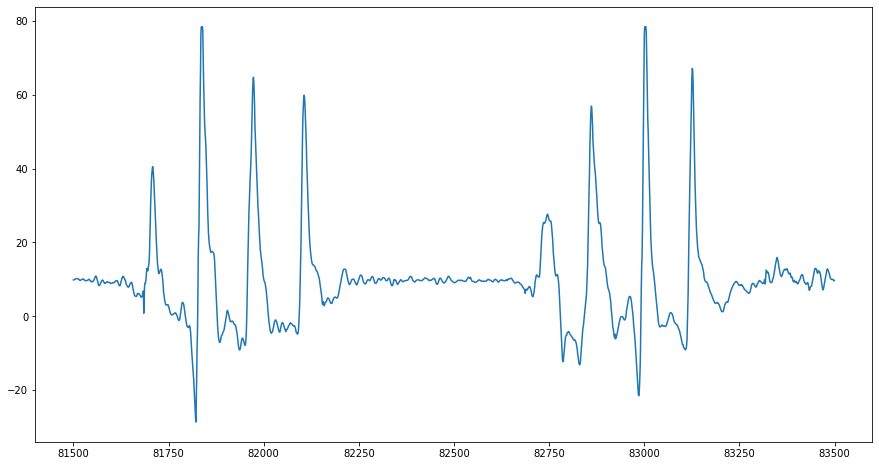

In [104]:
plt.plot(imu_data['az'][81500:83500])

In [105]:
find_peaks(imu_data['az'][81500:83500], height=50, width = 10)

(array([ 338,  473,  606, 1361, 1503, 1626]),
 {'peak_heights': array([78.44363 , 64.72964 , 59.85504 , 56.922146, 78.44363 , 67.128624]),
  'prominences': array([99.955532 , 73.873096 , 64.6817507, 70.07589  , 87.536808 ,
         65.9171579]),
  'left_bases': array([ 322,  437,  589, 1330,  322, 1608]),
  'right_bases': array([1485, 1485, 1485, 1485, 1608, 1706]),
  'widths': array([22.48985564, 24.93147199, 18.69565399, 35.00150515, 17.45937718,
         14.40294105]),
  'width_heights': array([28.465864  , 27.793092  , 27.51416465, 21.884201  , 34.675226  ,
         34.17004505]),
  'left_ips': array([ 330.37114376,  461.19648265,  599.03768013, 1352.41753523,
         1496.1531295 , 1619.27598101]),
  'right_ips': array([ 352.8609994 ,  486.12795464,  617.73333412, 1387.41904038,
         1513.61250668, 1633.67892206])})

### IMU End

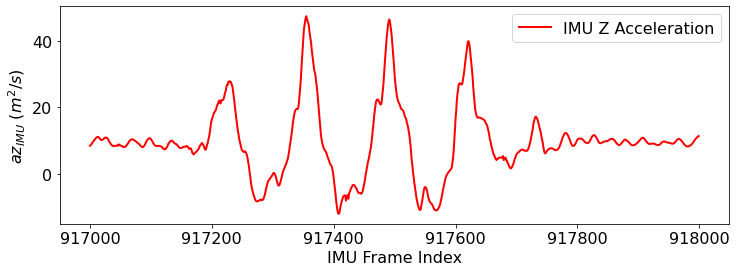

In [83]:
plt.plot(imu_data['az'][917000:918000], 'r',linewidth=lw, label='IMU Z Acceleration')
plt.legend(loc='best', ncol=1)
plt.xlabel("IMU Frame Index")
plt.ylabel("$az_{IMU}$ ($m^2/s$)")
plt.savefig('sync_imu.pdf', bbox_inches='tight')

In [107]:
find_peaks(imu_data['az'][917000:918000], height=30, width = 10)

(array([355, 491, 621]),
 {'peak_heights': array([47.342945, 46.368504, 39.88022 ]),
  'prominences': array([55.559845, 57.288458, 38.158789]),
  'left_bases': array([274, 408, 568]),
  'right_bases': array([408, 568, 690]),
  'widths': array([34.50675723, 49.51654413, 29.83037079]),
  'width_heights': array([19.5630225, 17.724275 , 20.8008255]),
  'left_ips': array([340.89130968, 466.56463609, 601.61992087]),
  'right_ips': array([375.39806691, 516.08118022, 631.45029166])})

In [108]:
find_peaks(imu_data['az'], height=26, width = 10)

(array([ 81708,  81838,  81973,  82106,  82746,  82861,  83003,  83126,
        917230, 917355, 917491, 917621]),
 {'peak_heights': array([40.512287, 78.44363 , 64.72964 , 59.85504 , 27.609934, 56.922146,
         78.44363 , 67.128624, 27.791893, 47.342945, 46.368504, 39.88022 ]),
  'prominences': array([39.68628744, 99.955532  , 73.873096  , 64.6817507 , 24.763228  ,
         70.07589   , 91.434568  , 76.221802  , 26.3266416 , 55.559845  ,
         58.337119  , 50.800174  ]),
  'left_bases': array([ 81685,  81822,  81937,  82089,  82159,  82830,  81822,  83108,
         710307, 917274, 917408, 917568]),
  'right_bases': array([ 81822,  82985,  82985,  82985,  82830,  82985, 919231, 919231,
         917274, 919231, 919231, 919231]),
  'widths': array([16.93990731, 22.48985564, 24.93147199, 18.69565399, 35.29895318,
         35.00150515, 18.11313129, 16.84353879, 43.2270262 , 34.50675723,
         50.65007231, 52.51929162]),
  'width_heights': array([20.66914328, 28.465864  , 27.793092 

81500 (array([ 338,  473,  606, 1361, 1503, 1626])

917000 (array([355, 491, 621])

The three anchor points in vicon starting jumps are:

[81838, 81973, 82106, 82861, 83003, 83126, 917355, 917491, 917621]

### Vicon Start

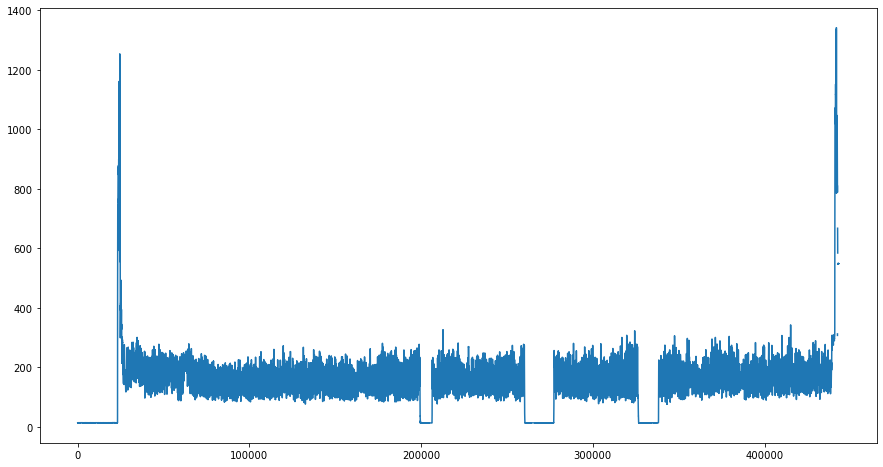

In [109]:
plt.plot(vicon_data['TZ'])

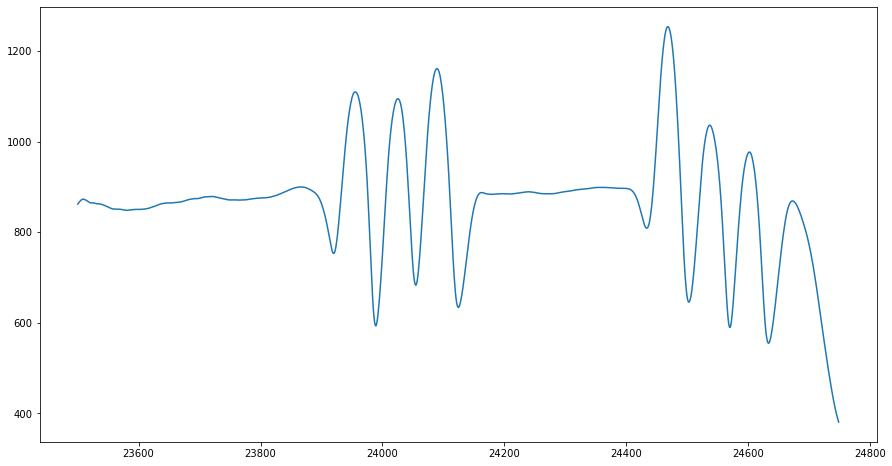

In [110]:
plt.plot(vicon_data['TZ'][23500:24750])

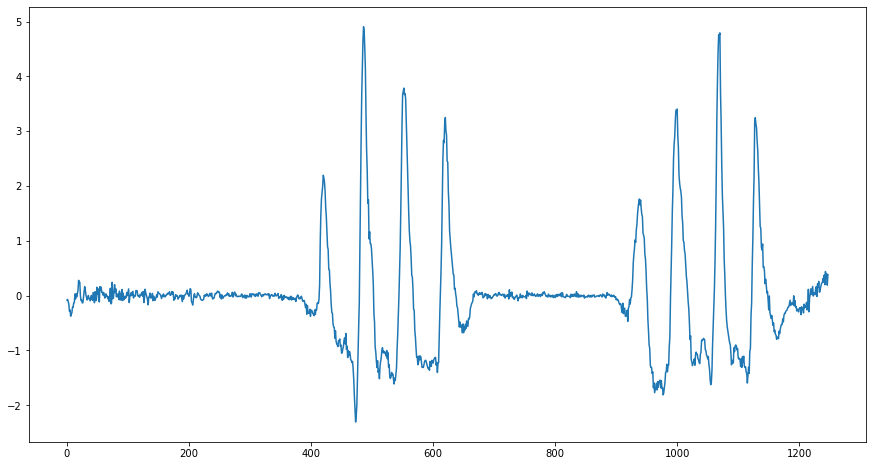

In [111]:
y_grad = np.diff(vicon_data['TZ'][23500:24750], 2)
plt.plot(y_grad)

In [112]:
find_peaks(-vicon_data['TZ'][500:1000], height=-900, width = 10)

(array([ 12,  54, 174, 230]),
 {'peak_heights': array([-13.5006, -13.4851, -13.479 , -13.4916]),
  'prominences': array([0.153 , 0.1871, 0.2064, 0.1843]),
  'left_bases': array([  7,  26, 150, 197]),
  'right_bases': array([ 26,  75, 249, 249]),
  'widths': array([11.9327336 , 11.91878398, 16.0980846 , 16.15294479]),
  'width_heights': array([-13.5771 , -13.57865, -13.5822 , -13.58375]),
  'left_ips': array([  7.57174888,  49.6512931 , 170.51997095, 216.39821429]),
  'right_ips': array([ 19.50448248,  61.57007708, 186.61805556, 232.55115907])})

In [113]:
find_peaks(y_grad, height=3, width = 10)

(array([ 486,  552,  620, 1000, 1070, 1128]),
 {'peak_heights': array([4.906, 3.786, 3.249, 3.403, 4.793, 3.247]),
  'prominences': array([6.716, 5.397, 4.65 , 5.028, 6.387, 4.044]),
  'left_bases': array([ 473,  536,  607,  977,  977, 1115]),
  'right_bases': array([ 977,  977,  977, 1055, 1115, 1163]),
  'widths': array([13.68119797, 15.18474369, 14.75632184, 20.6492915 , 11.39795834,
         12.72843818]),
  'width_heights': array([1.548 , 1.0875, 0.924 , 0.889 , 1.5995, 1.225 ]),
  'left_ips': array([ 480.60131951,  546.34257871,  613.93333333,  990.92307692,
         1063.39025822, 1124.2887538 ]),
  'right_ips': array([ 494.28251748,  561.5273224 ,  628.68965517, 1011.57236842,
         1074.78821656, 1137.01719198])})

To think about this physically:

The experimenter takes the phone and jumps 3 times. Each time, at the lowest point, the legs are yet to reach maximum strength. It's only after a while that the muscle will be in full tension. So there should be a slight delay in max acceleration relative to lowest point. 

As demonstrated here, the peaks of TZ's 2nd-derivative are slightly later than valleys of TZ.

23500 array([ 486,  552,  620, 1000, 1070, 1128])

The three anchor points in vicon starting jumps are:

[23986, 24052, 24120, 24500, 24570, 24628]

### Vicon End

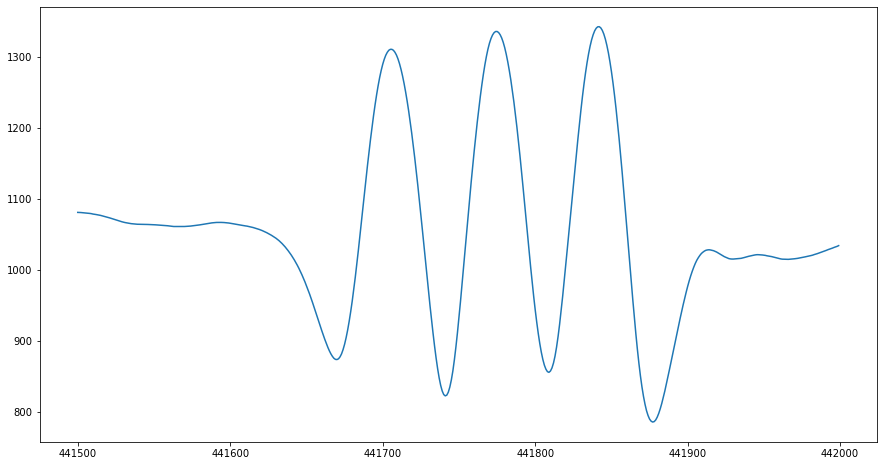

In [114]:
plt.plot(vicon_data['TZ'][441500:442000])

In [64]:
y_grad = np.diff(vicon_data['TZ'][441558:442058], 2)
y_idx = np.array(range(442058 - 441560)) + 441558

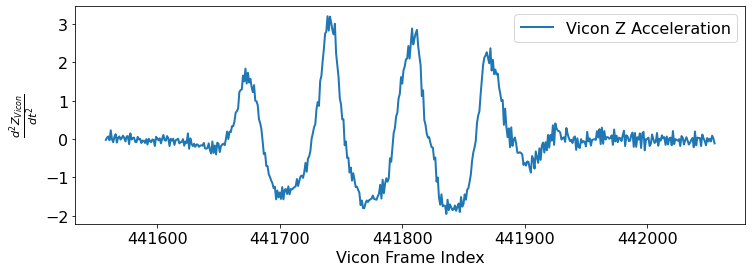

In [84]:
plt.plot(y_idx, y_grad, linewidth=lw, label='Vicon Z Acceleration')
plt.legend(loc='best', ncol=1)
plt.xlabel("Vicon Frame Index")
plt.ylabel(r'$\frac{d^2Z_{Vicon}}{dt^2}$')
plt.savefig('sync_vicon.pdf', bbox_inches='tight')

In [62]:
regressor.predict([[917000]])

array([441558.50604868])

In [63]:
regressor.predict([[918000]])

array([442058.49577113])

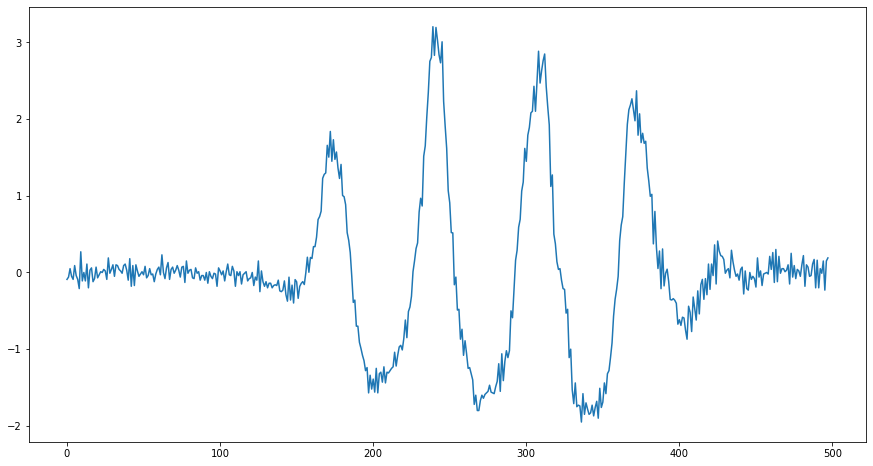

In [115]:
y_grad = np.diff(vicon_data['TZ'][441500:442000], 2)
plt.plot(y_grad)

In [116]:
find_peaks(y_grad, height=2, width = 10)

(array([239, 308, 372]),
 {'peak_heights': array([3.205, 2.885, 2.369]),
  'prominences': array([4.775, 4.685, 3.239]),
  'left_bases': array([203, 269, 336]),
  'right_bases': array([336, 336, 405]),
  'widths': array([20.06473914, 23.10328152, 19.36831903]),
  'width_heights': array([0.8175, 0.5425, 0.7495]),
  'left_ips': array([230.16850829, 294.84166667, 363.04886364]),
  'right_ips': array([250.23324742, 317.94494819, 382.41718266])})

441500 array([239, 308, 372])

[441729, 441808, 441872]

## Fit

In [50]:
imu_frames = [81838, 81973, 82106, 82861, 83003, 83126, 917355, 917491, 917621]

In [51]:
vicon_frames = [23986, 24052, 24120, 24500, 24570, 24628, 441729, 441808, 441872]

In [52]:
imu_frames = np.array(imu_frames).reshape(-1, 1)

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
regressor = LinearRegression().fit(imu_frames, vicon_frames)

In [55]:
regressor.coef_

array([0.49998972])

In [56]:
regressor.intercept_

-16932.06943973023

## Align

In [57]:
imu_start = 90000
imu_end = 910000

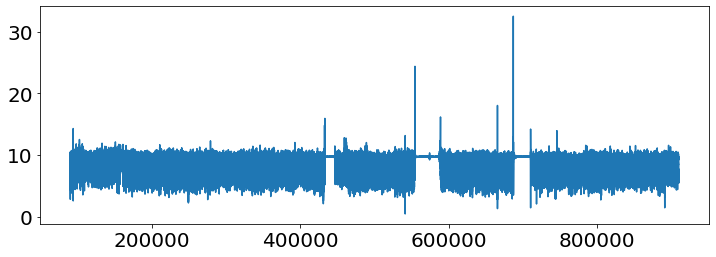

In [58]:
plt.plot(imu_data['az'][90000:910000])

In [59]:
regressor.predict([[90000]])

array([28067.00558094])

In [60]:
regressor.predict([[910000]])

array([438058.57799151])

In [128]:
vicon_start = 28067
vicon_end = 438058

In [129]:
imu_excerpt = imu_data[:][90000:910000].reset_index()

In [130]:
imu_excerpt

,index,Timestamp,gx,gy,gz,ax,ay,az
0,90000,2501943224913545,-0.222355,0.207083,-0.034208,7.098808,0.943315,7.161058
1,90001,2501943229918391,-0.240681,0.208916,-0.061697,6.998251,0.936133,7.268796
2,90002,2501943235935084,-0.260229,0.199142,-0.090408,6.940791,0.902614,7.225701
3,90003,2501943239928007,-0.270002,0.194866,-0.116675,6.873753,0.866701,7.264008
4,90004,2501943244932930,-0.269392,0.183260,-0.136834,6.900089,0.816423,7.331046
...,...,...,...,...,...,...,...,...
819995,909995,2506043200325972,-0.035430,-0.265726,-0.038485,-7.522582,0.416591,6.457162
819996,909996,2506043205330895,-0.041539,-0.270002,-0.049480,-7.453150,0.414197,6.485892
819997,909997,2506043210305126,-0.045204,-0.273057,-0.056810,-7.486669,0.462081,6.567295
819998,909998,2506043215331280,-0.045815,-0.279776,-0.065973,-7.469909,0.433351,6.665458


In [131]:
vicon_excerpt = vicon_data[:][28063:438063].reset_index()

In [132]:
vicon_excerpt

,index,Frame,Sub Frame,RX,RY,RZ,RW,TX,TY,TZ
0,28063,28064,0.0,0.064229,-0.347300,0.024403,0.935234,-177.569,-59.6127,119.971
1,28064,28065,0.0,0.062920,-0.346718,0.024566,0.935534,-177.706,-59.2730,120.289
2,28065,28066,0.0,0.062004,-0.346413,0.024806,0.935702,-177.768,-58.8930,120.675
3,28066,28067,0.0,0.061004,-0.345869,0.024704,0.935972,-177.840,-58.5937,121.054
4,28067,28068,0.0,0.059815,-0.345125,0.024616,0.936325,-177.900,-58.2343,121.556
...,...,...,...,...,...,...,...,...,...,...
409995,438058,438059,0.0,0.023186,0.412834,-0.005962,0.910492,236.504,-29.7379,148.716
409996,438059,438060,0.0,0.023123,0.411553,-0.006018,0.911073,235.809,-29.4345,149.821
409997,438060,438061,0.0,0.022754,0.410316,-0.005975,0.911640,235.128,-29.3206,150.688
409998,438061,438062,0.0,0.022496,0.409084,-0.006207,0.912198,234.457,-29.1803,151.626


In [133]:
vicon_excerpt = np.array(vicon_excerpt)

In [134]:
imu_excerpt = np.array(imu_excerpt)

In [135]:
# change vicon data from (x, y, z, w) to (w, x, y, z)
rx = vicon_excerpt[:, 3].copy()
ry = vicon_excerpt[:, 4].copy()
rz = vicon_excerpt[:, 5].copy()
rw = vicon_excerpt[:, 6].copy()
vicon_excerpt[:, 3] = rw
vicon_excerpt[:, 4] = rx
vicon_excerpt[:, 5] = ry
vicon_excerpt[:, 6] = rz

## Subtract Gravity

In [136]:
vicon_excerpt[1][3:7]

array([ 0.935534 ,  0.06292  , -0.346718 ,  0.0245661])

In [123]:
gravity = np.array([0,0,9.8])
for i in range(124000):
    q = Quaternion(vicon_excerpt[i][3:7])
    gravity_r = q.conjugate.rotate(gravity)
    imu_excerpt[2*i][5:8] = imu_excerpt[2*i][5:8] - gravity_r
    imu_excerpt[2*i+1][5:8] = imu_excerpt[2*i+1][5:8] - gravity_r

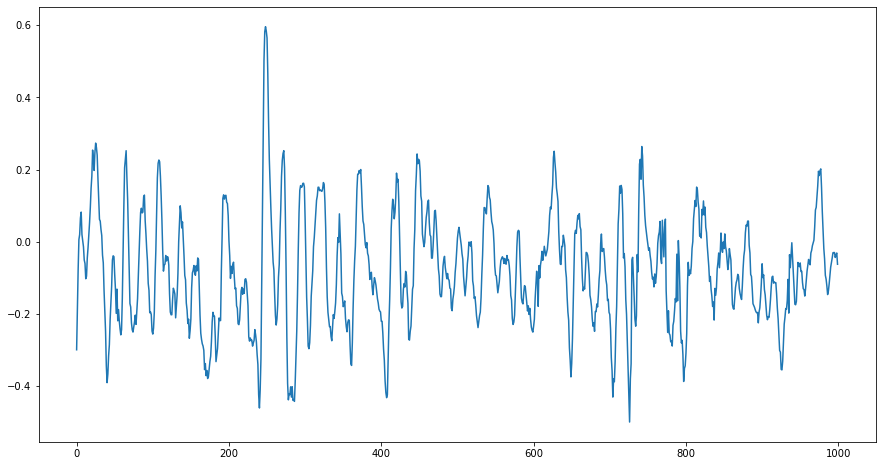

In [135]:
plt.plot(imu_excerpt[50000:51000,5])

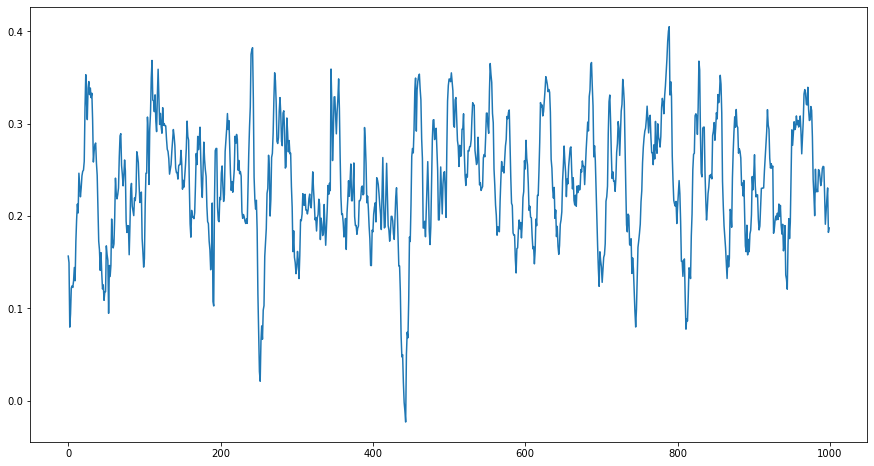

In [136]:
plt.plot(imu_excerpt[50000:51000,6])

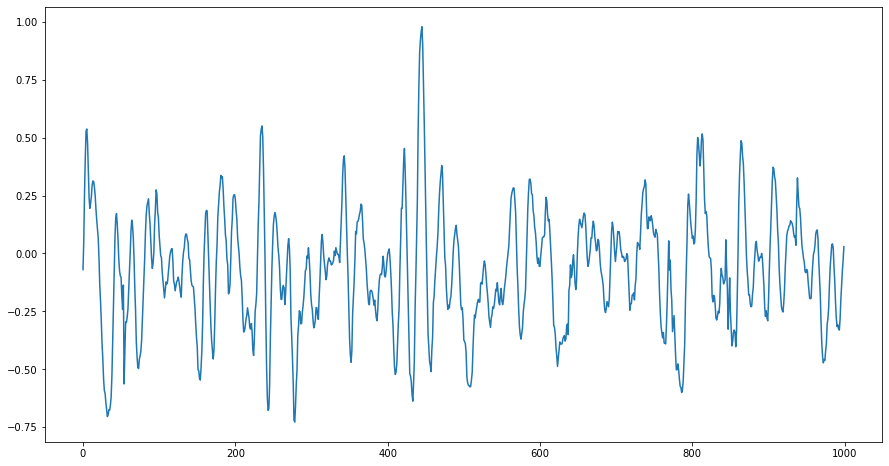

In [137]:
plt.plot(imu_excerpt[50000:51000,7])

## Create Data in Stride

In [140]:
# length of imu training data sequence
dl = 50
# interval of vicon sequence
di = int(dl/2)
# stride of imu training data sequence
dt = 10
# stride of vicon sequence
ds = int(dt/2)
# length of data
len_m = int((imu_excerpt.shape[0] - dl) / dt)

In [141]:
len_m

81995

In [142]:
data_x = np.zeros((len_m, dl*6))
data_y = np.zeros((len_m, 7))
data_gt = np.zeros((len_m, 7))

In [143]:
data_x.shape

(81995, 300)

In [144]:
from pyquaternion import Quaternion

In [145]:
def get_rotation(a, b):
    a = Quaternion(a)
    b = Quaternion(b)
    rotation = a.inverse * b # a * rotation = b
    return rotation.elements

In [146]:
from scipy import integrate

In [147]:
def fill_integrate(a):
    a[:,6] = integrate.cumtrapz(a[:,3], initial=0)
    a[:,7] = integrate.cumtrapz(a[:,4], initial=0)
    a[:,8] = integrate.cumtrapz(a[:,5], initial=0)
    a[:,9] = integrate.cumtrapz(a[:,6], initial=0)
    a[:,10] = integrate.cumtrapz(a[:,7], initial=0)
    a[:,11] = integrate.cumtrapz(a[:,8], initial=0)

In [148]:
for i in range(len_m):
    start_imu = i * dt
    end_imu = start_imu + dl
    start_vicon = i * ds
    end_vicon = start_vicon + di
#     imu_tmp = np.zeros((dl, 12))
#     imu_tmp[:,:6] = imu_excerpt[start_imu:end_imu,2:8].copy()
#     fill_integrate(imu_tmp)
#     data_x[i] = imu_tmp.reshape(dl*12)
    data_x[i] = imu_excerpt[start_imu:end_imu,2:8].copy().reshape(dl*6)
    data_y[i][0:4] = get_rotation(vicon_excerpt[start_vicon][3:7], 
                                  vicon_excerpt[end_vicon][3:7]) # start * rotation = end
    init_rotation = Quaternion(vicon_excerpt[start_vicon][3:7])
    data_y[i][4:7] = init_rotation.rotate(vicon_excerpt[end_vicon][7:10] - vicon_excerpt[start_vicon][7:10])
    data_gt[i][0:4] = vicon_excerpt[start_vicon][3:7]
    data_gt[i][4:7] = vicon_excerpt[start_vicon][7:10]

In [149]:
data_x.shape

(81995, 300)

In [99]:
np.savetxt('x_50_10_3.csv', data_x, delimiter=",")

In [97]:
np.savetxt('y_50_10_3.csv', data_y, delimiter=",")

In [98]:
np.savetxt('gt_50_10_3.csv', data_gt, delimiter=",")

In [95]:
vicon_excerpt[0][3:7]

array([ 0.935234 ,  0.0642294, -0.3473   ,  0.0244027])

In [96]:
vicon_excerpt[:, 3]

array([0.935234, 0.935534, 0.935702, ..., 0.91164 , 0.912198, 0.912851])

## Verification

In [381]:
len_draw = 30
start_seed = 0
traj_interval = dl//dt

In [413]:
draw_gt = np.zeros((len_draw+1, 3))
draw_y = np.zeros((len_draw+1, 3))
draw_dy = np.zeros((len_draw, 3))
draw_r = []

In [390]:
# draw trajectory from gt
for i in range(len_draw+1):
    i_data = start_seed + i * traj_interval
    draw_gt[i] = data_gt[i_data][4:7] - data_gt[start_seed][4:7]

In [414]:
# draw trajectory from y
draw_r.append(Quaternion(data_gt[start_seed][0:4]))
# draw_r.append(Quaternion([ 0.0459366,  0.0136608, -0.0125507,  0.998772 ]))
# draw_r.append(Quaternion([1,0,0,0]))
for i_draw, i_data in enumerate(range(start_seed, start_seed + len_draw * traj_interval, traj_interval)):
    draw_r.append(draw_r[i_draw] * Quaternion(data_y[i_data][0:4]))
    draw_y[i_draw+1] = draw_y[i_draw] + draw_r[i_draw].inverse.rotate(data_y[i_data][4:7])

In [412]:
data_gt[0][0:4]

array([ 0.998772 ,  0.0459366,  0.0136608, -0.0125507])

In [411]:
draw_r[0]

Quaternion(1.0, 0.0, 0.0, 0.0)

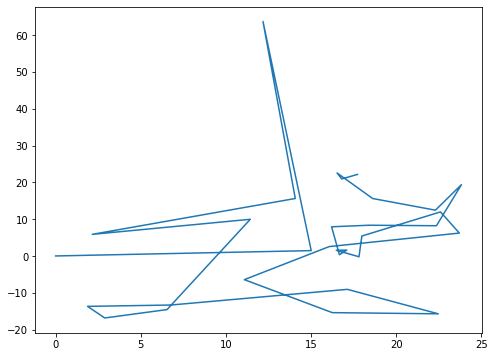

In [391]:
plt.plot(draw_gt[:,1], draw_gt[:,2])

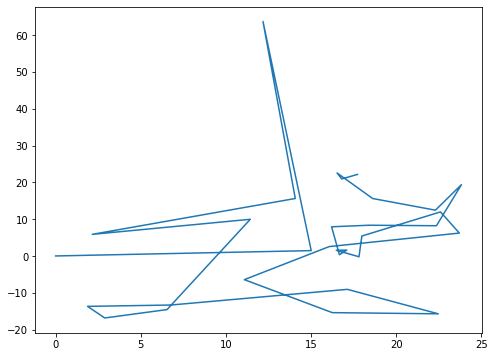

In [415]:
plt.plot(draw_y[:,1], draw_y[:,2])

In [408]:
draw_y[1]

array([20.71030625, 14.32404853,  2.24031979])

In [409]:
draw_gt[1]

array([20.2912, 15.0091,  1.452 ])

## Quaternion Test

In [298]:
q = Quaternion(0.5, 0.5, 0.5, 0.5)

In [327]:
q2 = q * q

In [325]:
q.rotate(q.rotate((1, 0, 0)))

(0.0, 0.0, 1.0)

In [328]:
q2.rotate((1, 0, 0))

(0.0, 0.0, 1.0)

In [329]:
q.inverse * q2

Quaternion(0.5, 0.5, 0.5, 0.5)

In [304]:
q.elements

array([0.5, 0.5, 0.5, 0.5])

In [392]:
data_gt[0]

array([ 9.98772e-01,  4.59366e-02,  1.36608e-02, -1.25507e-02,
        2.41740e+01, -2.95222e+01,  1.97188e+02])

In [394]:
data_gt[20]

array([ 9.98583e-01,  5.20390e-02,  9.03356e-03,  6.43505e-03,
        4.44652e+01, -1.45131e+01,  1.98640e+02])

In [397]:
rotation_gt = get_rotation(data_gt[0][0:4], data_gt[20][0:4])

In [399]:
translation_gt = data_gt[20][4:7] - data_gt[0][4:7]

In [405]:
translation_gt

array([20.2912, 15.0091,  1.452 ])

In [401]:
translation_y = Quaternion(data_gt[0][0:4]).rotate(translation_gt)

In [402]:
translation_y

array([20.71030625, 14.32404853,  2.24031979])

In [406]:
Quaternion(data_gt[0][0:4]).inverse.rotate(translation_y)

array([20.2912, 15.0091,  1.452 ])

In [252]:
np.array(imu_excerpt[['gx','gy','gz','ax','ay','az']][start_imu:end_imu]).reshape(dl*6).reshape(6,200)

array([[-8.55211400e-03,  4.09279730e-02, -4.27605700e-03, ...,
         9.70848750e+00, -1.22173050e-03, -2.44346100e-03],
       [ 4.21497000e-02, -8.11634360e-01,  6.41646000e-01, ...,
        -4.64257600e-02,  1.01403630e-01, -6.36857600e-01],
       [ 7.35019900e-01,  1.02854900e+01,  1.34390350e-02, ...,
        -9.02614060e-01,  8.21211160e-01,  9.98860900e+00],
       [ 1.22783914e-01, -1.19729586e-01, -3.66519160e-03, ...,
         9.11472600e+00,  2.50454750e-02, -2.05250730e-01],
       [ 1.16064400e-02, -5.07570740e-01,  9.88805300e-01, ...,
        -1.03847100e-02,  7.14712400e-02, -6.79953300e-01],
       [ 1.36708920e+00,  9.85453400e+00,  3.48193200e-01, ...,
        -2.34631760e-01,  1.57059630e+00,  9.34935800e+00]])

In [253]:
data_x.shape

(25980, 1200)

In [256]:
loss = pd.read_csv('test_loss.csv')

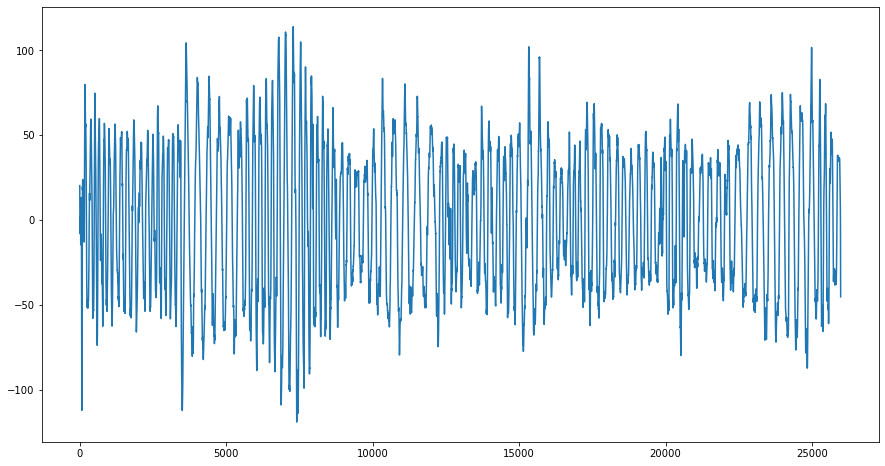

In [261]:
plt.plot(data_y[:, 4])

In [263]:
data_y[:, 4].std()

42.87602749718803

In [267]:
data_original = np.loadtxt('stride_x1.csv', delimiter=",")

In [269]:
data_original.shape

(3810, 1200)

In [271]:
np.transpose(data_original.reshape(3810, 6, 200), (0,2,1))

array([[[  7.6731 , -41.215  , -90.679  , -24.956  , -37.783  ,
          -3.8982 ],
        [  6.1175 , -42.164  , -90.785  , -26.864  , -36.062  ,
          -3.6911 ],
        [  6.3437 , -42.572  , -90.204  , -24.168  , -32.461  ,
          -3.6928 ],
        ...,
        [  3.6277 , -43.832  , -86.023  ,   4.344  ,   3.5395 ,
           5.6816 ],
        [  2.9015 , -44.31   , -85.888  ,   4.7947 ,   6.2003 ,
           5.144  ],
        [  2.0302 , -44.56   , -86.165  ,   4.0614 ,   7.4855 ,
           4.5001 ]],

       [[  5.6924 , -42.511  , -86.829  ,  12.247  ,  -0.4759 ,
          -1.5512 ],
        [  6.4723 , -43.54   , -86.415  ,  10.101  ,  -1.5246 ,
          -0.8059 ],
        [  6.7719 , -43.848  , -85.83   ,   6.2518 ,  -2.2386 ,
          -0.2779 ],
        ...,
        [  2.7338 , -43.351  , -88.801  ,   6.0999 , -11.381  ,
          -7.0974 ],
        [  2.0332 , -43.932  , -88.529  ,   5.0388 , -10.946  ,
          -7.6337 ],
        [  1.587  , -44.387  , -89.04

In [272]:
data_new = np.loadtxt('x.csv', delimiter=",")

In [289]:
len_draw = 30
start_seed = 0
traj_interval = 20
data_drawx = np.zeros((len_draw + 1, 200, 6))
data_drawy = np.zeros((len_draw + 1, 3))
for i_draw, i_data in enumerate(range(start_seed, start_seed + len_draw * traj_interval, traj_interval)):
#     data_drawx[i_draw + 1] = data_x[i_data]
    data_drawy[i_draw + 1] = data_drawy[i_draw] + data_y[i_data][4:7]

In [292]:
def draw_trajectory(gt_trajectory, pred_trajectory, figname):
    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].plot(gt_trajectory[:,0])
    axs[0, 0].plot(pred_trajectory[:,0])
    axs[0, 0].set_title('X-t')
    axs[0, 1].plot(gt_trajectory[:,1])
    axs[0, 1].plot(pred_trajectory[:,1])
    axs[0, 1].set_title('Y-t')
    axs[0, 2].plot(gt_trajectory[:,2])
    axs[0, 2].plot(pred_trajectory[:,2])
    axs[0, 2].set_title('Z-t')
    axs[1, 0].plot(gt_trajectory[:,0], gt_trajectory[:,1])
    axs[1, 0].plot(pred_trajectory[:,0], pred_trajectory[:,1])
    axs[1, 0].set_title('X-Y')
    axs[1, 1].plot(gt_trajectory[:,1], gt_trajectory[:,2])
    axs[1, 1].plot(pred_trajectory[:,1], pred_trajectory[:,2])
    axs[1, 1].set_title('Y-Z')
    axs[1, 2].plot(gt_trajectory[:,0], gt_trajectory[:,2])
    axs[1, 2].plot(pred_trajectory[:,0], pred_trajectory[:,2])
    axs[1, 2].set_title('X-Z')
    fig.savefig(figname)
    

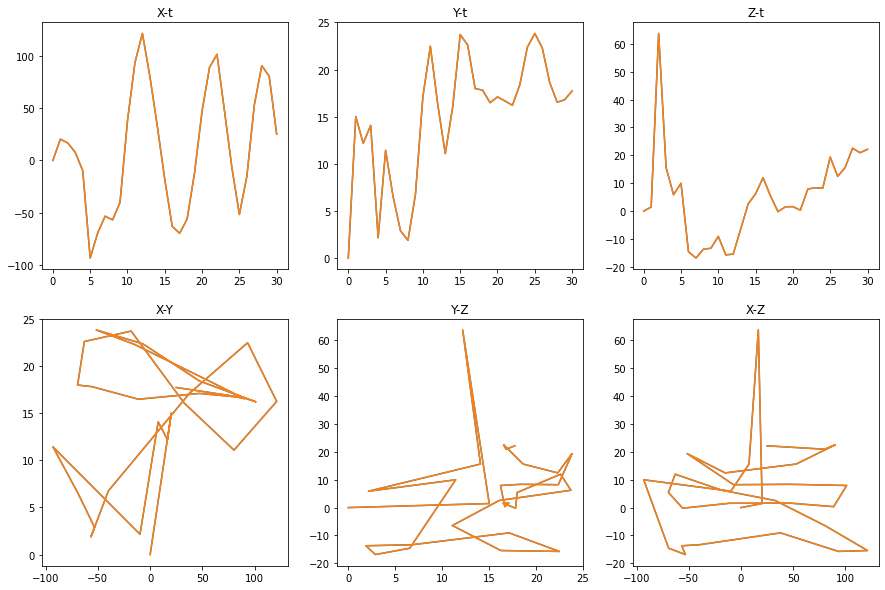

In [293]:
draw_trajectory(data_drawy, data_drawy, "test.jpg")

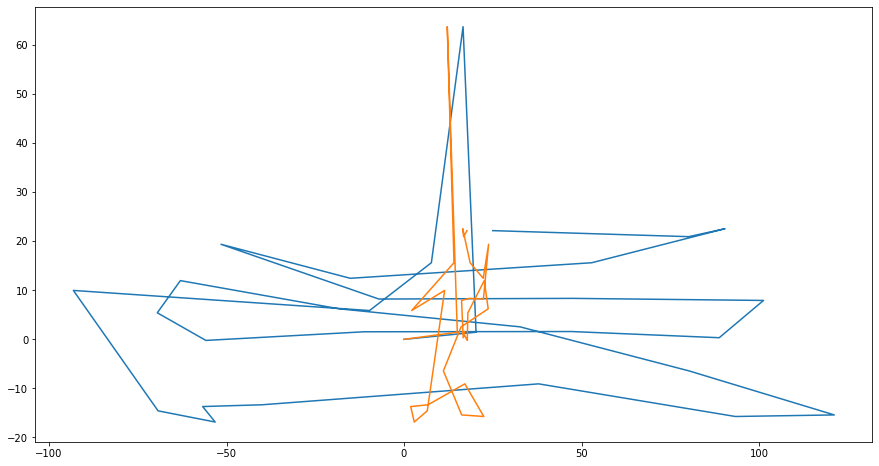

In [291]:
plt.plot(data_drawy[:,0], data_drawy[:,2])
plt.plot(data_drawy[:,1], data_drawy[:,2])

# Capture 1

In [35]:
820000 * 0.8 + 90000

746000.0

In [39]:
438063 - 82000

356063

In [36]:
imu_eval = imu_data[:][746000:910000].reset_index()

In [40]:
vicon_eval = vicon_data[:][356063:438063].reset_index()

In [61]:
vicon_spliter_right = find_peaks(vicon_eval["TX"], height=200, width = 200)[0]

In [62]:
vicon_spliter_left = find_peaks(-vicon_eval["TX"], height=100, width = 200)[0]

In [73]:
vicon_spliter = np.sort(np.concatenate((vicon_spliter_right, vicon_spliter_left)))

In [90]:
vicon_windows_raw = []
vicon_windows = []
imu_windows_raw = []
imu_windows = []

In [91]:
for i in range(len(vicon_spliter)-1):
    vicon_windows_raw.append([vicon_spliter[i], vicon_spliter[i+1]])
    imu_windows_raw.append([vicon_spliter[i]*2, vicon_spliter[i+1]*2])

In [92]:
for i in imu_windows_raw:
    if i[1] - i[0] > 600:
        imu_windows.append(i)

In [93]:
for i in vicon_windows_raw:
    if i[1] - i[0] > 300:
        vicon_windows.append(i)

In [137]:
imu_eval = np.array(imu_eval)

In [138]:
vicon_eval = np.array(vicon_eval)

In [139]:
rx = vicon_eval[:, 3].copy()
ry = vicon_eval[:, 4].copy()
rz = vicon_eval[:, 5].copy()
rw = vicon_eval[:, 6].copy()
vicon_eval[:, 3] = rw
vicon_eval[:, 4] = rx
vicon_eval[:, 5] = ry
vicon_eval[:, 6] = rz

In [156]:
for counter, window in enumerate(imu_windows):
    length = (window[1] - window[0]) // dl
    data_x = np.zeros((length, dl*6))
    data_y = np.zeros((length, 7))
    data_gt = np.zeros((length+1, 7))
    for i in range(length):
        imu_a = window[0] + dl * i
        imu_b = imu_a + dl
        vicon_a = imu_a // 2
        vicon_b = imu_b // 2
        data_x[i] = imu_eval[imu_a:imu_b,2:8].copy().reshape(dl*6)
        data_y[i][0:4] = get_rotation(vicon_eval[vicon_a][3:7], vicon_eval[vicon_b][3:7])
        init_rotation = Quaternion(vicon_eval[vicon_a][3:7])
        data_y[i][4:7] = init_rotation.rotate(vicon_eval[vicon_b][7:10] - vicon_eval[vicon_a][7:10])
        data_gt[i][0:4] = vicon_eval[vicon_a][3:7]
        data_gt[i][4:7] = vicon_eval[vicon_a][7:10]
    data_gt[length][0:4] = vicon_eval[vicon_b][3:7]
    data_gt[length][4:7] = vicon_eval[vicon_b][7:10]
    np.savetxt('./eval/eval_' + str(counter) + '_x.csv', data_x, delimiter=",")
    np.savetxt('./eval/eval_' + str(counter) + '_y.csv', data_y, delimiter=",")
    np.savetxt('./eval/eval_' + str(counter) + '_gt.csv', data_gt, delimiter=",")

In [152]:
500 // 50

10

In [ ]:
ate = np.array([53.1052174  24.57283227 75.60055194 44.01132548 88.18244461 35.04667379
 33.1170975  17.53768389 20.46903756 35.47627465 30.89371449 22.51964663
 35.75864478 46.64341069 33.4767477  31.11101258 36.38497336 25.39437389
 23.01541545 40.5867387  46.3722745  17.7100159  46.15263231 33.23908293
 53.9857079  26.42303433 18.32492123 29.66269646 29.69419822 36.48804576
 24.84931571 22.76135513 51.1589339  26.53957149 23.48016486 22.86347155
 34.82632636 37.98347213 29.08711595 45.90685557 47.16126121 30.36267736
 13.1487714  20.1502324  25.89043891 25.48149946 38.22227765 10.04813396
 39.94161168 17.3533981  30.71548863 27.9844728  29.84535735 49.5403549
 53.05810154 50.87090625 23.67184337 33.87743655 23.3506194  35.56998581
 27.45537282 34.60282873 33.59371804 21.3904823  51.95553357 39.72636211
 73.82781152 45.01185911 48.7687704  42.53053688 58.75853809 24.69976066
 81.52860859 49.50505782 48.39070895 36.22027107 29.80176628 20.21218605
 41.20644883 37.58120301 63.0515201  35.43474115 24.52961075 33.0986683
 32.70798006 59.01999587 39.17887421 35.33642842 34.71451144 25.49704868
 23.42978073 20.29395461 46.80368416 31.83151777 25.80069926 48.99307923
 23.22009827 45.85532406 53.91683232 55.27663051 32.4200113  34.15820077
 29.07692461 45.73644853 67.67333278 30.11258751 39.55234394 23.47058306
 46.28126654 23.96288823 32.52536887 28.55068059 53.27898471 37.34459613
 28.60342073 12.87988442 26.11320618 27.68902559 27.22872513 35.74718155
 33.95040939 19.58108001 19.51127478 33.32972394 59.87819217 24.30021484
 37.6286765  43.10973393 42.84822479 36.2812984  39.08871704 34.32089044
 24.55808812 43.30699468 34.96869816 47.33151858 36.17679733 18.02333232
 42.85336407 40.26218157 43.92170884 49.03453987 48.97055222 32.96727338
 56.51373495 42.09719701 57.12833106 31.14840594 22.93410585 34.62909848
 44.86401758 53.05914786 32.79589801 41.24828686 27.64856056 73.12293959
 54.95053697 52.20098509 46.77705705 48.67292094 40.39482578 37.12394868
 44.6204288  28.55366506 23.55893241 43.04875299 62.09727821 91.56234974
 42.76202108 63.53872334 32.12219072 43.89890368 37.17321141 39.08735114
 71.94918269 59.86005833 53.55941709 21.88314516 39.7763915  36.3339823
 28.29033201 28.55095162 39.1993321  18.1583491  27.90704414 38.35121821
 56.27626409 34.41298641]
)

In [159]:
ate_string = "[53.1052174  24.57283227 75.60055194 44.01132548 88.18244461 35.04667379 33.1170975 17.53768389 20.46903756 35.47627465 30.89371449 22.51964663 35.75864478 46.64341069 33.4767477 31.11101258 36.38497336 25.39437389 23.01541545 40.5867387 46.3722745  17.7100159  46.15263231 33.23908293 53.9857079 26.42303433 18.32492123 29.66269646 29.69419822 36.48804576 24.84931571 22.76135513 51.1589339 26.53957149 23.48016486 22.86347155 34.82632636 37.98347213 29.08711595 45.90685557 47.16126121 30.36267736 13.1487714  20.1502324  25.89043891 25.48149946 38.22227765 10.04813396 39.94161168 17.3533981  30.71548863 27.9844728  29.84535735 49.5403549 53.05810154 50.87090625 23.67184337 33.87743655 23.3506194  35.56998581 27.45537282 34.60282873 33.59371804 21.3904823  51.95553357 39.72636211 73.82781152 45.01185911 48.7687704  42.53053688 58.75853809 24.69976066 81.52860859 49.50505782 48.39070895 36.22027107 29.80176628 20.21218605 41.20644883 37.58120301 63.0515201  35.43474115 24.52961075 33.0986683 32.70798006 59.01999587 39.17887421 35.33642842 34.71451144 25.49704868 23.42978073 20.29395461 46.80368416 31.83151777 25.80069926 48.99307923 23.22009827 45.85532406 53.91683232 55.27663051 32.4200113  34.15820077 29.07692461 45.73644853 67.67333278 30.11258751 39.55234394 23.47058306 46.28126654 23.96288823 32.52536887 28.55068059 53.27898471 37.34459613 28.60342073 12.87988442 26.11320618 27.68902559 27.22872513 35.74718155 33.95040939 19.58108001 19.51127478 33.32972394 59.87819217 24.30021484 37.6286765  43.10973393 42.84822479 36.2812984  39.08871704 34.32089044 24.55808812 43.30699468 34.96869816 47.33151858 36.17679733 18.02333232 42.85336407 40.26218157 43.92170884 49.03453987 48.97055222 32.96727338 56.51373495 42.09719701 57.12833106 31.14840594 22.93410585 34.62909848 44.86401758 53.05914786 32.79589801 41.24828686 27.64856056 73.12293959 54.95053697 52.20098509 46.77705705 48.67292094 40.39482578 37.12394868 44.6204288  28.55366506 23.55893241 43.04875299 62.09727821 91.56234974 42.76202108 63.53872334 32.12219072 43.89890368 37.17321141 39.08735114 71.94918269 59.86005833 53.55941709 21.88314516 39.7763915  36.3339823 28.29033201 28.55095162 39.1993321  18.1583491  27.90704414 38.35121821 56.27626409 34.41298641]"

In [162]:
np.char.replace(ate_string, ' ', ',')

array('[53.1052174,24.57283227,75.60055194,44.01132548,88.18244461,35.04667379,33.1170975,17.53768389,20.46903756,35.47627465,30.89371449,22.51964663,35.75864478,46.64341069,33.4767477,31.11101258,36.38497336,25.39437389,23.01541545,40.5867387,46.3722745,17.7100159,46.15263231,33.23908293,53.9857079,26.42303433,18.32492123,29.66269646,29.69419822,36.48804576,24.84931571,22.76135513,51.1589339,26.53957149,23.48016486,22.86347155,34.82632636,37.98347213,29.08711595,45.90685557,47.16126121,30.36267736,13.1487714,20.1502324,25.89043891,25.48149946,38.22227765,10.04813396,39.94161168,17.3533981,30.71548863,27.9844728,29.84535735,49.5403549,53.05810154,50.87090625,23.67184337,33.87743655,23.3506194,35.56998581,27.45537282,34.60282873,33.59371804,21.3904823,51.95553357,39.72636211,73.82781152,45.01185911,48.7687704,42.53053688,58.75853809,24.69976066,81.52860859,49.50505782,48.39070895,36.22027107,29.80176628,20.21218605,41.20644883,37.58120301,63.0515201,35.43474115,24.52961075,33.0986683,32

In [161]:
ate_string = "[53.1052174,24.57283227 75.60055194 44.01132548 88.18244461 35.04667379 33.1170975,17.53768389 20.46903756 35.47627465 30.89371449 22.51964663 35.75864478 46.64341069 33.4767477,31.11101258 36.38497336 25.39437389 23.01541545 40.5867387,46.3722745,17.7100159,46.15263231 33.23908293 53.9857079,26.42303433 18.32492123 29.66269646 29.69419822 36.48804576 24.84931571 22.76135513 51.1589339,26.53957149 23.48016486 22.86347155 34.82632636 37.98347213 29.08711595 45.90685557 47.16126121 30.36267736 13.1487714,20.1502324,25.89043891 25.48149946 38.22227765 10.04813396 39.94161168 17.3533981,30.71548863 27.9844728,29.84535735 49.5403549 53.05810154 50.87090625 23.67184337 33.87743655 23.3506194,35.56998581 27.45537282 34.60282873 33.59371804 21.3904823,51.95553357 39.72636211 73.82781152 45.01185911 48.7687704,42.53053688 58.75853809 24.69976066 81.52860859 49.50505782 48.39070895 36.22027107 29.80176628 20.21218605 41.20644883 37.58120301 63.0515201,35.43474115 24.52961075 33.0986683 32.70798006 59.01999587 39.17887421 35.33642842 34.71451144 25.49704868 23.42978073 20.29395461 46.80368416 31.83151777 25.80069926 48.99307923 23.22009827 45.85532406 53.91683232 55.27663051 32.4200113,34.15820077 29.07692461 45.73644853 67.67333278 30.11258751 39.55234394 23.47058306 46.28126654 23.96288823 32.52536887 28.55068059 53.27898471 37.34459613 28.60342073 12.87988442 26.11320618 27.68902559 27.22872513 35.74718155 33.95040939 19.58108001 19.51127478 33.32972394 59.87819217 24.30021484 37.6286765,43.10973393 42.84822479 36.2812984,39.08871704 34.32089044 24.55808812 43.30699468 34.96869816 47.33151858 36.17679733 18.02333232 42.85336407 40.26218157 43.92170884 49.03453987 48.97055222 32.96727338 56.51373495 42.09719701 57.12833106 31.14840594 22.93410585 34.62909848 44.86401758 53.05914786 32.79589801 41.24828686 27.64856056 73.12293959 54.95053697 52.20098509 46.77705705 48.67292094 40.39482578 37.12394868 44.6204288,28.55366506 23.55893241 43.04875299 62.09727821 91.56234974 42.76202108 63.53872334 32.12219072 43.89890368 37.17321141 39.08735114 71.94918269 59.86005833 53.55941709 21.88314516 39.7763915,36.3339823 28.29033201 28.55095162 39.1993321,18.1583491,27.90704414 38.35121821 56.27626409 34.41298641]"

In [163]:
ate = np.array([53.1052174,24.57283227,75.60055194,44.01132548,88.18244461,35.04667379,33.1170975,17.53768389,20.46903756,35.47627465,30.89371449,22.51964663,35.75864478,46.64341069,33.4767477,31.11101258,36.38497336,25.39437389,23.01541545,40.5867387,46.3722745,17.7100159,46.15263231,33.23908293,53.9857079,26.42303433,18.32492123,29.66269646,29.69419822,36.48804576,24.84931571,22.76135513,51.1589339,26.53957149,23.48016486,22.86347155,34.82632636,37.98347213,29.08711595,45.90685557,47.16126121,30.36267736,13.1487714,20.1502324,25.89043891,25.48149946,38.22227765,10.04813396,39.94161168,17.3533981,30.71548863,27.9844728,29.84535735,49.5403549,53.05810154,50.87090625,23.67184337,33.87743655,23.3506194,35.56998581,27.45537282,34.60282873,33.59371804,21.3904823,51.95553357,39.72636211,73.82781152,45.01185911,48.7687704,42.53053688,58.75853809,24.69976066,81.52860859,49.50505782,48.39070895,36.22027107,29.80176628,20.21218605,41.20644883,37.58120301,63.0515201,35.43474115,24.52961075,33.0986683,32.70798006,59.01999587,39.17887421,35.33642842,34.71451144,25.49704868,23.42978073,20.29395461,46.80368416,31.83151777,25.80069926,48.99307923,23.22009827,45.85532406,53.91683232,55.27663051,32.4200113,34.15820077,29.07692461,45.73644853,67.67333278,30.11258751,39.55234394,23.47058306,46.28126654,23.96288823,32.52536887,28.55068059,53.27898471,37.34459613,28.60342073,12.87988442,26.11320618,27.68902559,27.22872513,35.74718155,33.95040939,19.58108001,19.51127478,33.32972394,59.87819217,24.30021484,37.6286765,43.10973393,42.84822479,36.2812984,39.08871704,34.32089044,24.55808812,43.30699468,34.96869816,47.33151858,36.17679733,18.02333232,42.85336407,40.26218157,43.92170884,49.03453987,48.97055222,32.96727338,56.51373495,42.09719701,57.12833106,31.14840594,22.93410585,34.62909848,44.86401758,53.05914786,32.79589801,41.24828686,27.64856056,73.12293959,54.95053697,52.20098509,46.77705705,48.67292094,40.39482578,37.12394868,44.6204288,28.55366506,23.55893241,43.04875299,62.09727821,91.56234974,42.76202108,63.53872334,32.12219072,43.89890368,37.17321141,39.08735114,71.94918269,59.86005833,53.55941709,21.88314516,39.7763915,36.3339823,28.29033201,28.55095162,39.1993321,18.1583491,27.90704414,38.35121821,56.27626409,34.41298641])

In [165]:
ate.shape

(188,)

In [172]:
def draw_ate_hist(ate, figname):
    plt.rcParams['figure.figsize'] = [8, 6]
    fig, axs = plt.subplots()
    axs.hist(ate)
    axs.set_title('ATE histogram')
    axs.set_xlabel('ATE(mm)')
    axs.set_ylabel('Count')
    fig.savefig(figname)
    plt.close('all')

In [173]:
draw_ate_hist(ate, "ate_test.jpg")